# 4-2 Dataset と DataLoader の実装

## マスクデータとは
ここで使用する画像データには，小さくしか写っていない，単純にアノテーションデータがないだけなどの理由で，人が写っているのに姿勢情報のアノテーションが存在しないデータもある．
こうしたデータは姿勢推定の学習に悪影響を及ぼす．  
そこで，画像中に写ってはいるがアノテーションのない人物に関しては黒く塗りつぶすマスクをかけておく．
これをマスクデータと呼ぶ．
OpenPose の学習時には損失関数の計算時に，画像から検出された座標位置に対してマスクデータを照合し，マスクされたピクセルに関しては損失の計算から除外する．

## フォルダの準備
毎度のように，make_folders_and_data_downloads.ipynb を実行する．

## 画像・アノテーション・マスクデータへのファイルパスリストを作成
画像データ、アノテーションデータ、マスクデータへのファイルパスリストを作成する．
画像データに関しては COCO.json に記載されている画像のみを data/val2014 から取り出して使用する．

In [1]:
import os.path as osp
import json

def make_datapath_list(rootpath):
    ''' 学習、検証の画像・アノテーション・マスクデータへのファイルパスリストを作成 '''
    
    # アノテーションの JSON ファイルの読み込み
    json_path = osp.join(rootpath, "COCO.json")
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this["root"]
        
    # index を格納
    num_samples = len(data_json)
    train_indices = []
    val_indices = []
    for count in range(num_samples):
        if data_json[count]["isValidation"] != 0.0:
            val_indices.append(count)
        else:
            train_indices.append(count)
            
    # 画像ファイルパスを作成
    train_img_list = list()
    val_img_list = list()
    
    for idx in train_indices:
        img_path = osp.join(rootpath, data_json[idx]["img_paths"])
        train_img_list.append(img_path)
        
    for idx in val_indices:
        img_path = osp.join(rootpath, data_json[idx]["img_paths"])
        val_img_list.append(img_path)
        
    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []
    
    for idx in train_indices:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indices:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)
        
    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()
    
    for idx in train_indices:
        train_meta_list.append(data_json[idx])
        
    for idx in val_indices:
        val_meta_list.append(data_json[idx])
        
    return train_img_list, val_img_list, train_mask_list, val_mask_list, train_meta_list, val_meta_list

In [2]:
# 動作確認
train_img_list, val_img_list, train_mask_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath="./data/")
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

## マスクデータの働きを確認
マスクデータがどのように動作するか確認する．
以下のコードを実行すると遠くの人物がマスクされる．

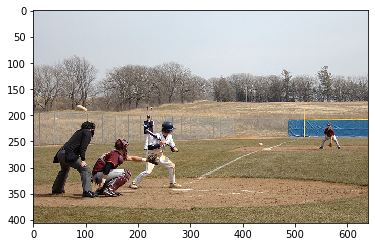

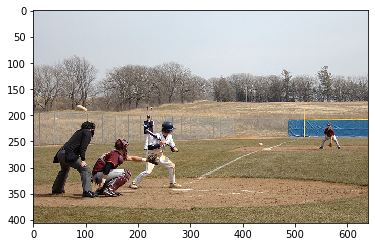

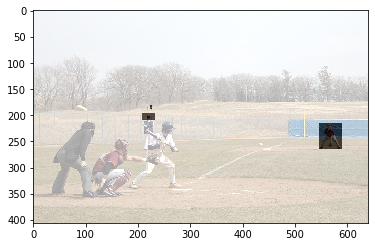

In [3]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

index = 24

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 8)
plt.imshow(blend_img)
plt.show()

## 画像の前処理作成
画像とアノテーションデータに対して前処理を行う DataTransform クラスを作成する．
前処理を行うためのコードは utils/data_augumentation.py にまとめてある．  
まず，対象の画像データ，アノテーションデータ，マスクデータをセットで変換するための Compose クラスを作成する．
訓練データに対しては get_anno クラスで JSON 形式のアノテーションデータを Python の辞書型変数に変換する．
その後，add_neck クラスで首のアノテーションデータの座標位置を作成し，身体部位のアノテーションデータの順番を MS COCO から OpenPose で使用されている形式に変換する．
首の位置情報は MS COCO のアノテーションデータの右肩と左肩の中間を計算し首の位置情報とする．
首のアノテーションデータを追加するのは，たとえば推論時に画像内で首は写っているが右肩が写っている人物の場合でも，首の位置を推論することで首から下の身体部位について推論しやすくして精度を高めることが出来るためである．  
次に，データオーギュメンテーションを行う．
画像のサイズを aug_scale クラスで 0.5 ~ 1.1 倍の幅で拡大・縮小する．
その後，aug_rotate で -40 ~ 40 度の間でランダムに回転させる．
さらに，aug_cropped クラスで，アノテーションデータの joint_self キーで指定されたメインの人物を中心に，画像を縦横364ピクセルで切り出す．
そして，aug_flip クラスで 50% の確率で左右を反転させる．  
最後に remove_illegal_joint クラスで切り出した画像から身体部位がなくなったアノテーションデータの情報を修正する．
ここまでの操作で，メインの人物の体の一部や joint_others キーで指定されたアノテーションされている人物が切り出した画像に含まれていない可能性がある．
そのような場合，アノテーションデータの座標情報のうち「視認性」を「画像に写っておらずアノテーションもなし」へ変更する．  
前処理の最後に Nomalize_Tensor クラスで色情報を標準化し，PyTorch のテンソル型に変換する．
ここでは，前処理の結果が確認しやすいように色情報の標準化を行わないクラス no_Nomalize_Tensor も用意している．
また，本章では OpenPose の学習を簡易的に確認するに留めるため，検証データを使用するフェーズは省略している．

In [4]:
import cv2
import numpy as np
from PIL import Image
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint
from utils.data_augumentation import Normalize_Tensor, no_Normalize_Tensor

In [7]:
class DataTransform():
    """
    画像，マスク，アノテーションの前処理クラス
    学習時と推論時で異なる動作をする
    学習時はデータオーギュメンテーションする
    """
    
    def __init__(self):
        self.data_transform = {
            "train": Compose([
                get_anno(),            # JSON からアノテーションを辞書に格納
                add_neck(),            # アノテーションデータの順番変更と首の位置情報の追加
                aug_scale(),           # 拡大・縮小
                aug_rotate(),          # 回転
                aug_croppad(),         # 切り出し
                aug_flip(),            # 左右反転
                remove_illegal_joint(),# 画像からはみ出したアノテーションを除去
                Normalize_Tensor()     # 色情報の標準化とテンソル化
               #no_Normalize_Tensor()  # 色情報の標準化を行わない（本節のみ）
            ]),
            "val": Compose([
                # 本章では省略
            ])
        }
        
    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)
        return meta_data, img, mask_miss

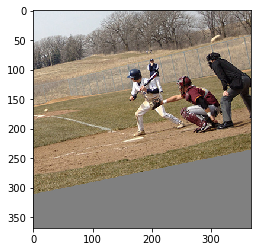

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


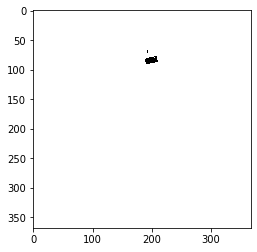

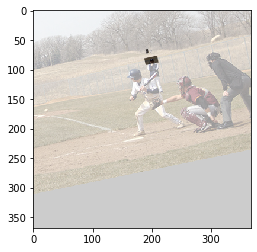

In [6]:
# 動作確認

# 画像の読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

#  前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

# 画像の表示
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# マスクの表示
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# RGB に揃えてから合成
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 訓練データの正解情報として使うアノテーションデータの作成
OpenPose の学習と検証で使用するアノテーションデータについて，さらに処理を施す．  
はじめに，特定のピクセルで与えられている MS COCO の身体部位のアノテーションデータに対して，そのピクセルを中心とするガウス分布を考え，部位情報のアノテーションを OpenPose 用に作り直す．
このアノテーションを今後 heatmaps と呼ぶ．  
次に，PAFs のアノテーション情報を作成する．
PAFs は基本的に部位間の直線上にあるピクセルは1に，その他のピクセルは0にした長方形のような形になる．  
これら heatmaps と PAFs を生成するコードは utils/data_loader.py の get_ground_truth 関数として実装している．
実装の詳細はコードのコメントを参照のこと．
また，heatmaps と PAFs のサイズは，OpenPose の Feature モジュールの出力サイズに合わせて 46×46 サイズとなっている．

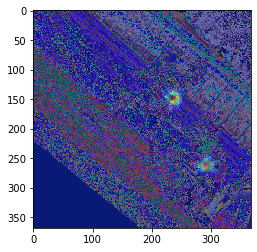

In [9]:
from matplotlib import cm
from utils.data_loader import get_ground_truth

# 画像の読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

#  前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose のアノテーションデータを作成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 左肘の heatmaps を確認
# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 左肘
heat_map = heatmaps[:, :, 6] # 6 は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
# 画像サイズが小さくなっているので元に戻す
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

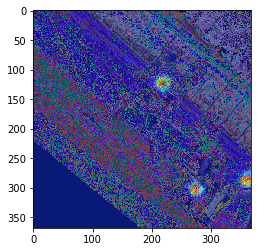

In [10]:
# 左手首
heat_map = heatmaps[:, :, 7] # 7 は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

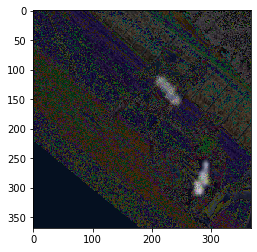

In [11]:
# 左肘と左手首への PAF を確認
paf = pafs[:, :, 24] # 24 は左肘と左手首をつなぐ
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

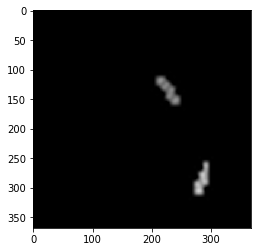

In [12]:
# PAF のみを表示
paf = pafs[:, :, 24] # 24 は左肘と左手首をつなぐ
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)

## Dataset の作成
COCOkeypointDataset クラスとして Dataset を作成する．
インスタンス生成時には，画像データへのパスリスト，アノテーションデータのパスリスト，マスクデータへのパスリスト，学習か検証かを指定する phase，前処理クラスのインスタンス DataTransform() を渡す．  
マスクデータは RGB で (255, 255, 255) または (0, 0, 0) として表され，マスクは (0, 0, 0) で与えられる．
この3次元のマスク情報を1次元に落とし，マスクされていて無視したい部分を0に，そうでない部分は1に変換する．
また，チャンネル情報を一番最後の次元から最初の次元に置き換える．  
ここでは簡易な学習を体験するだけに留めるので，訓練データはダウンロードしていない．
そのため，訓練用の Dataset にも検証用ファイルのリストを引数に与えている．

In [17]:
import torch.utils.data as data
from utils.data_loader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCOのCocokeypointsのDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス

    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーション、マスクを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. マスクとアノテーション読み込み
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 画像前処理
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 正解アノテーションデータの取得
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. マスクデータはRGBが(1,1,1)か(0,0,0)なので、次元を落とす
        # マスクデータはマスクされている場所は値が0、それ以外は値が1です
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. チャネルが最後尾にあるので順番を変える
        # 例：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask

In [18]:
# 動作確認
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# データの取り出し例
item = train_dataset.__getitem__(0)
print(item[0].shape) # img
print(item[1].shape) # heatmaps,
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


## DataLoader の作成


In [19]:
# データローダの作成
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val":val_dataloader}

In [20]:
# 動作の確認
batch_iterator = iter(dataloaders_dict["train"]) # イタレータに変換
item = next(batch_iterator) # 1 番目の要素を取り出す
print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
